In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
import torch.utils.data
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as Func
import timm
import cv2

## Datasets Selection

### Training Set
   - **Description**: Contains 999 real ultrasound images.
   - **Measurements**: Includes already labeled pixel size values.

### Test Set
   - **Description**: Contains 335 real ultrasound images.
   - **Measurements**: Includes already labeled pixel size values.

### GAN Set
   - **Description**: Contains 4689 fake ultrasound images.
   - **Measurements**: Pixel size values were measured using a model trained only on the training and test sets.


In [2]:
include_gan = True

# Read the CSV files
train_csv = pd.read_csv("/kaggle/input/fetalhcdata/training_set/training_set_circumference.csv")
test_csv = pd.read_csv("/kaggle/input/fetalhcdata/test_set/test_set_circumference.csv")
if include_gan:
    gan_csv = pd.read_csv("/kaggle/input/fetalhcdata/gan_set_v2/measured_circumference.csv")

# Define image paths
train_img = "/kaggle/input/fetalhcdata/training_set/training_set"
test_img = "/kaggle/input/fetalhcdata/test_set/test_set"
if include_gan:
    gan_img = "/kaggle/input/fetalhcdata/gan_set_v2/gan_images"

# Add 'dataset' column
train_csv['dataset'] = 'train'
test_csv['dataset'] = 'test'
if include_gan:
    gan_csv['dataset'] = 'gan'

# Concatenate the dataframes
dfs_to_concat = [train_csv, test_csv]
if include_gan:
    dfs_to_concat.append(gan_csv)

## Data Preprocessing and Class Balancing
#### This code categorizes samples based on head circumference. It limits the number of samples per class based on `limit_per_class` to ensure balanced representation. The priority order is applied to select samples for removal in case of excess (highest priority starts from the right side). The resulting dataset, 'filtered_df', contains balanced samples across classes.

#### Also, the code cluster classes where we identified a small number of samples from training_set. For example, when classifying circumference, we have barely any samples in the first classes 4 and 5, so we set `lowest_value_cm` as 6 to combine them under class number 6.

#### Lastly, we have two optinal variables to adjust the sample distribution: `gan_samples_limit` allows to limit the number of GAN samples in each class, and `oversample_limit` upsamples all classes with fewer samples than the limit.

In [3]:
# Concatenate the dataframes
merged_df = pd.concat(dfs_to_concat)

# Define parameters based on classification type
lowest_value_cm, highest_value_cm, limit_per_class = 6, 33, 220
oversample_limit = 130

# Calculate class based on the scale factor
merged_df['class'] = np.round(merged_df['Head_Circumference_cm'])

# Generate the classes list
classes = list(range(lowest_value_cm, highest_value_cm + 1))

# Priority order
priority = ['gan', 'test', 'train']

merged_df.loc[(merged_df['class'] <= lowest_value_cm), 'class'] = lowest_value_cm
merged_df.loc[(merged_df['class'] > highest_value_cm), 'class'] = highest_value_cm

validation_ratio = 0.2

# Extract 20% of samples from all datasets and 20% from 'train' dataset
extracted_samples_test = []
extracted_samples_train = []
extracted_samples_gan = []
for cir_class in classes:
    samples_in_class = merged_df[merged_df['class'] == cir_class]
    #sample_count_gan = len(samples_in_class[samples_in_class['dataset'] == 'gan'])
    #sample_count_test = len(samples_in_class[samples_in_class['dataset'] == 'test'])
    sample_count_train = len(samples_in_class[samples_in_class['dataset'] == 'train'])
    
    if sample_count_train > 1:
        extract_count_train = max(1, int(sample_count_train * validation_ratio))
        extracted_samples_train.append(samples_in_class[samples_in_class['dataset'] == 'train'].sample(n=extract_count_train, random_state=42))
        
    #if sample_count_gan > 1:
    #    extract_count_gan = max(1, int(sample_count_gan * validation_ratio)) 
    #    extracted_samples_gan.append(samples_in_class[samples_in_class['dataset'] == 'gan'].sample(n=extract_count_gan, random_state=42))
        
    #if sample_count_test > 1:
    #    extract_count_test = max(1, int(sample_count_test * validation_ratio))
    #    extracted_samples_test.append(samples_in_class[samples_in_class['dataset'] == 'test'].sample(n=extract_count_test, random_state=42))

# Combine the extracted samples into a single DataFrame
extracted_samples = extracted_samples_test + extracted_samples_train + extracted_samples_gan
if extracted_samples:
    extracted_df = pd.concat(extracted_samples)
    # Remove the extracted samples from the merged_df
    indices_to_keep = ~merged_df.set_index(['dataset', 'filename']).index.isin(extracted_df.set_index(['dataset', 'filename']).index)
    merged_df = merged_df.loc[indices_to_keep]
else:
    extracted_df = pd.DataFrame()

limit_gan_samples = True

# Iterate over each class
for cir_class in classes:
    
    if not include_gan or not limit_gan_samples:
        continue
    
    # Filter real samples for the current class
    real_samples_in_class = merged_df[(merged_df['class'] == cir_class) & ((merged_df['dataset'] == 'test') | (merged_df['dataset'] == 'train'))]
    
    # Count real samples to set as limit for GAN samples
    gan_samples_limit = len(real_samples_in_class)
    
    # Filter GAN samples for the current class
    gan_samples_in_class = merged_df[(merged_df['class'] == cir_class) & (merged_df['dataset'] == 'gan')]
    
    # Check if 'new_gan' exists in the dataset
    if 'gan_new' in merged_df['dataset'].unique():
        new_gan_samples_in_class = merged_df[(merged_df['class'] == cir_class) & (merged_df['dataset'] == 'gan_new')]
        
        # Combine GAN and new_gan samples
        combined_gan_samples = pd.concat([gan_samples_in_class, new_gan_samples_in_class])
        
        if len(combined_gan_samples) <= gan_samples_limit:
            continue
        
        # Determine how many GAN + new_gan samples exceed the limit
        samples_to_remove = len(combined_gan_samples) - gan_samples_limit
        
        # Sample the excess GAN images to remove
        excess_samples = combined_gan_samples.sample(n=samples_to_remove, random_state=42)
        
        # Create a mask to filter out the excess samples
        indices_to_keep = ~merged_df.set_index(['dataset', 'filename']).index.isin(excess_samples.set_index(['dataset', 'filename']).index)
        
    else:
        if len(gan_samples_in_class) <= gan_samples_limit:
            continue
        
        # Determine how many GAN samples exceed the limit
        samples_to_remove = len(gan_samples_in_class) - gan_samples_limit
        
        # Sample the excess GAN images to remove
        excess_samples = gan_samples_in_class.sample(n=samples_to_remove, random_state=42)
        
        # Create a mask to filter out the excess samples
        indices_to_keep = ~merged_df.set_index(['dataset', 'filename']).index.isin(excess_samples.set_index(['dataset', 'filename']).index)
    
    # Update merged_df to only include samples that are not excess GAN samples
    merged_df = merged_df.loc[indices_to_keep]

# Limit class samples
for cir_class in classes:
    samples_in_class = merged_df[merged_df['class'] == cir_class]
    
    if len(samples_in_class) == 0:
        print(f"Class {cir_class - lowest_value_cm} has no samples")

    if len(samples_in_class) <= limit_per_class:
        continue

    excess_count = len(samples_in_class) - limit_per_class
    
    for dataset in priority:
        if excess_count <= 0:
            break
        dataset_samples = samples_in_class[(samples_in_class['dataset'] == dataset)]
        if len(dataset_samples) > 0:
            samples_to_remove = min(len(dataset_samples), excess_count)
            excess_samples = dataset_samples.sample(n=samples_to_remove, random_state=42)
            indices_to_keep = ~merged_df.set_index(['dataset', 'filename']).index.isin(excess_samples.set_index(['dataset', 'filename']).index)
            merged_df = merged_df.loc[indices_to_keep]
            excess_count -= samples_to_remove

# Oversample samples in each class until reaching limit_per_class amount of samples
for cir_class in classes:
    samples_in_class = merged_df[merged_df['class'] == cir_class]
    
    if len(samples_in_class) < oversample_limit:
        needed_samples = oversample_limit - len(samples_in_class)
        oversampled_samples = samples_in_class.sample(n=needed_samples, replace=True, random_state=42)
        merged_df = pd.concat([merged_df, oversampled_samples])

# Create a new merged_df with the filtered data
merged_df = merged_df.drop(columns=['class'])

val_df = pd.concat(extracted_samples_train)
val_df = val_df.drop(columns=['class'])

filtered_df = merged_df.copy()

# Display the filtered dataframe
filtered_df.head()

,filename,Head_Circumference_cm,Head_Circumference_mm,pixel size(mm),OFD,BPD,mask_filename,dataset
0,000_HC.png,4.430,44.30,0.069136,23.9,15.4,000_HC_Mask.png,train
1,001_HC.png,5.681,56.81,0.089659,25.7,23.3,001_HC_Mask.png,train
2,012_HC.png,5.940,59.40,0.083460,29.3,22.7,012_HC_Mask.png,train
3,004_HC.png,5.981,59.81,0.061240,30.7,21.6,004_HC_Mask.png,train
4,014_3HC.png,6.026,60.26,0.077308,28.1,24.1,014_3HC_Mask.png,train


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = 4 if torch.cuda.is_available() else 0
print(device)

cuda


## Data Classification (for data visualization)
#### The `classify_head_measurements` function categorizes measurements into classes by rounding the cm measurements and normalizing them to start from 0. It returns the number of unique classes and a mapping of original class labels to normalized ones.

In [5]:
def classify_head_measurements(df):
    def round_classification(value):
        rounded_value = int(np.round(value))
        if rounded_value <= lowest_value_cm:
            return lowest_value_cm
        elif rounded_value > highest_value_cm:
            return highest_value_cm
        else:
            return rounded_value

    df['classes'] = df['Head_Circumference_cm'].apply(round_classification)
    
    # Normalize class labels to start from 0
    unique_classes = sorted(df['classes'].unique())
    class_mapping = {old_class: new_class for new_class, old_class in enumerate(unique_classes)}
    df['classes'] = df['classes'].map(class_mapping)
    
    num_classes = df['classes'].nunique()

    return num_classes, class_mapping

num_classes, class_mapping = classify_head_measurements(filtered_df)
classify_head_measurements(val_df)
balanced_df = filtered_df.copy()

print("Class Mapping:", class_mapping)
print("Number of Classes:", num_classes)

Class Mapping: {6: 0, 7: 1, 8: 2, 9: 3, 10: 4, 11: 5, 12: 6, 13: 7, 14: 8, 15: 9, 16: 10, 17: 11, 18: 12, 19: 13, 20: 14, 21: 15, 22: 16, 23: 17, 24: 18, 25: 19, 26: 20, 27: 21, 28: 22, 29: 23, 30: 24, 31: 25, 32: 26, 33: 27}
Number of Classes: 28


## Plot Class Distribution Across Datasets

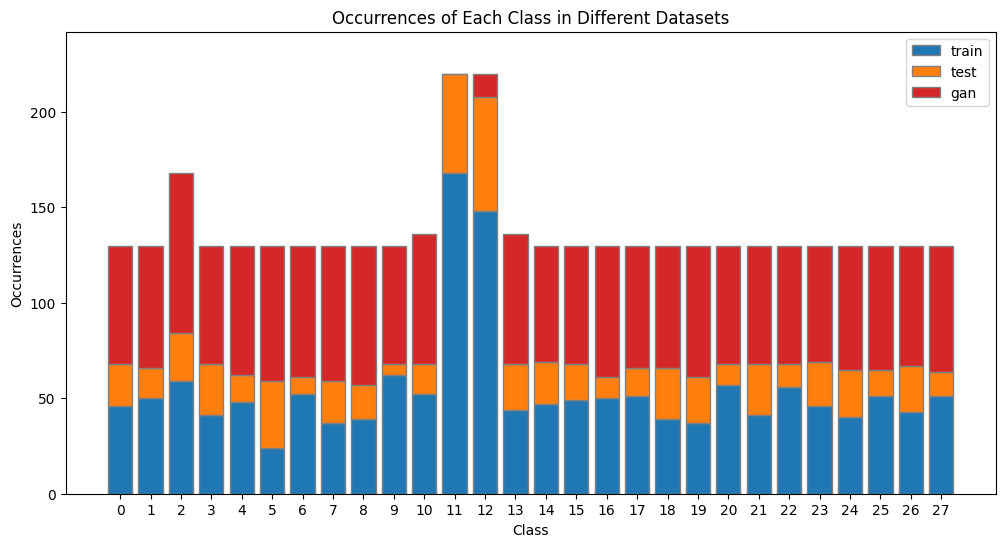

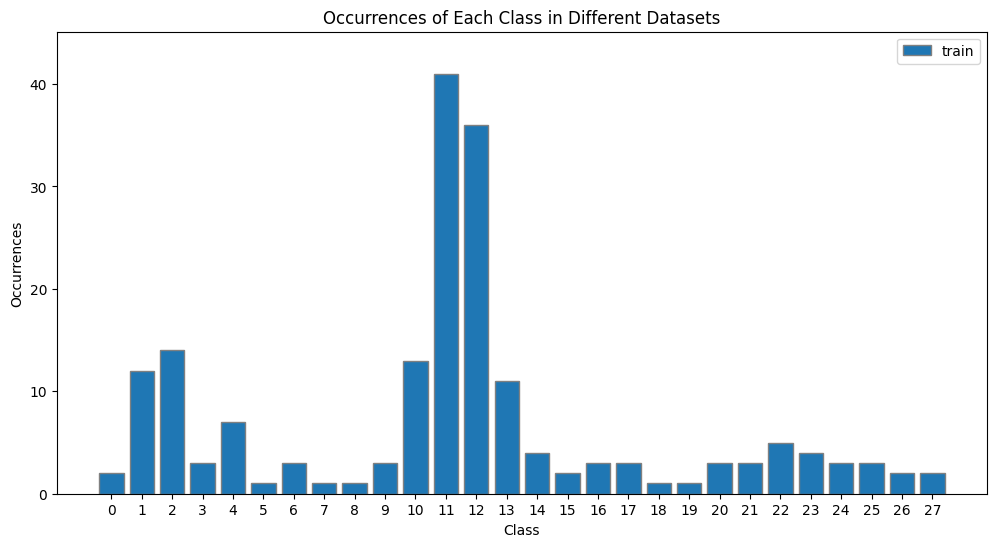

In [6]:
def plot_class_distribution(df, dataset_colors=None):
    # Make a copy of the DataFrame to avoid altering the original
    df_copy = df.copy()
    
    # Identify unique datasets in the 'dataset' column
    unique_datasets = df_copy['dataset'].unique()

    # Initialize a dictionary to hold class counts for each dataset
    class_counts_dict = {}

    # Loop through each unique dataset and count class occurrences
    for dataset in unique_datasets:
        dataset_data = df_copy[df_copy['dataset'] == dataset]
        class_counts = dataset_data['classes'].value_counts().sort_index()
        class_counts_dict[dataset] = class_counts

    # Combine the counts into a single DataFrame
    class_counts = pd.DataFrame(class_counts_dict).fillna(0)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Default colors if dataset_colors is not provided
    default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    if dataset_colors is None:
        dataset_colors = {}
    
    # Bar width
    bar_width = 0.35

    # Initialize bottom for stacked bars
    bottom = None

    for i, dataset in enumerate(class_counts.columns):
        if bottom is None:
            bottom = np.zeros_like(class_counts[dataset])

        # Get color for current dataset
        color = dataset_colors.get(dataset, default_colors[i % len(default_colors)])

        ax.bar(class_counts.index, class_counts[dataset], bottom=bottom, color=color, edgecolor='grey', label=dataset)
        bottom += class_counts[dataset]

    # Add labels
    ax.set_xlabel('Class')
    ax.set_ylabel('Occurrences')
    ax.set_title('Occurrences of Each Class in Different Datasets')
    ax.legend()

    # Set x-axis tick labels with class numbers
    ax.set_xticks(range(len(class_counts)))
    ax.set_xticklabels(class_counts.index)

    # Increase y-axis limit a little more than the top value
    max_count = class_counts.sum(axis=1).max()
    ax.set_ylim(0, max_count * 1.1)

    # Show plot
    plt.show()

dataset_colors = {'train': '#1f77b4', 'test': '#ff7f0e', 'gan': '#d62728', 'gan_new': '#9467bd'}
plot_class_distribution(balanced_df, dataset_colors)
plot_class_distribution(val_df, dataset_colors)

## Initialize PSDataset Class

In [7]:
class PSDataset(Dataset):
    def __init__(self, df, dataset_paths, transform_X=None):
        self.X = [
            os.path.join(dataset_paths[dataset], filename)
            for filename, dataset in zip(df['filename'], df['dataset'])
        ]
        self.Y = df['pixel size(mm)'].astype(float).tolist()
        self.dataset = df['dataset'].tolist()
        self.hc = df['Head_Circumference_mm'].astype(float).tolist()
        self.transform_X = transform_X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Extract the image
        img_path = self.X[idx]
        image = Image.open(img_path)

        # Extract name and value from the dataframe
        filename = os.path.basename(img_path)
        value = self.Y[idx]
        circumference = self.hc[idx]
        dataset = self.dataset[idx]

        if self.transform_X:
            image = self.transform_X(image)
            image = image.to(torch.float32)

        # Convert target value to torch.float32
        value = torch.tensor(value, dtype=torch.float32).unsqueeze(0)

        return image, value, circumference, dataset

In [8]:
img_size = 512

transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

transform_val = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [9]:
dataset_paths = {
    'train': train_img,
    'test': test_img,
}

if include_gan:
    dataset_paths['gan'] = gan_img

train_dataset = PSDataset(balanced_df, dataset_paths, transform_train)
val_dataset = PSDataset(val_df, dataset_paths, transform_val)

## Testing Class Output

In [10]:
print(len(train_dataset))
print(len(val_dataset))

3870
187


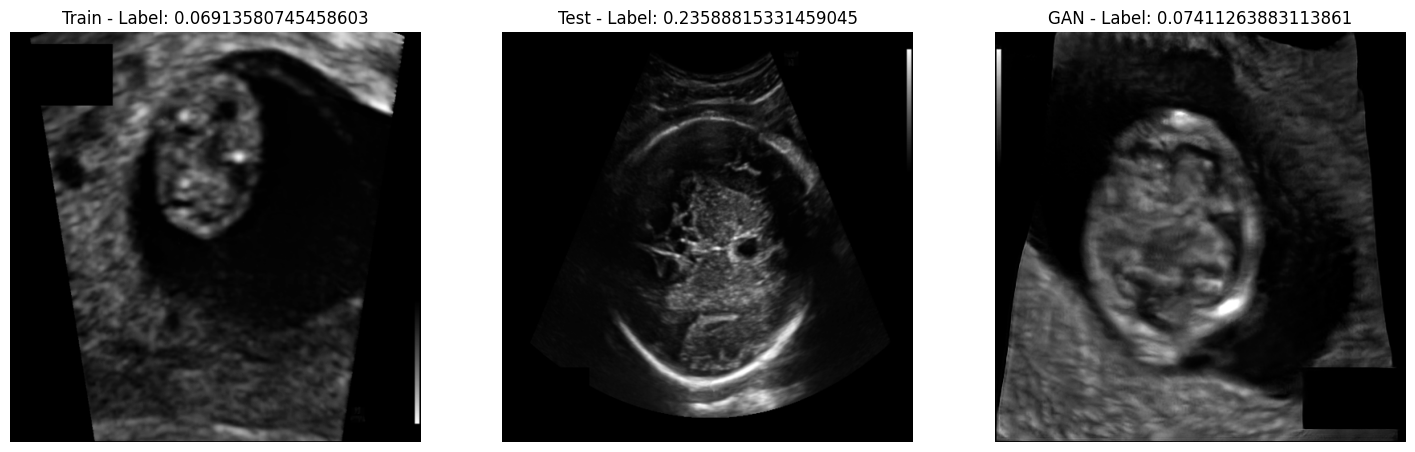

In [11]:
def plot_sample(dataset, index, title, ax):
    image, pixel_size, circumference, _ = dataset[index]

    ax.imshow(image.squeeze(), cmap='gray')  # Squeeze to remove channel dimension for grayscale
    ax.set_title(f"{title} - Label: {pixel_size.item()}")
    ax.axis('off')

# Plot samples from the datasets
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

train_sample_idx = 0
plot_sample(train_dataset, train_sample_idx, "Train", axes[0])

test_sample_idx = len(train_csv)
plot_sample(train_dataset, test_sample_idx, "Test", axes[1])

if include_gan:
    gan_sample_idx = len(train_csv) + len(test_csv)
    plot_sample(train_dataset, gan_sample_idx, "GAN", axes[2])

plt.show()

## Dividing Data for Cross Validation

In [12]:
# Select batch size
batch_size = 5

# Cross-validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=workers)

## Training the Model

In [13]:
from torch.optim.lr_scheduler import OneCycleLR

def train_and_validate(model, train_loader, validation_loader, criterion, optimizer, epochs=5, max_lr=0.01, train_loss_threshold=None):
    train_running_loss_history = []
    validation_running_loss_history = []
    lr_history = []
    prev_val_loss = float('inf')
    early_stop = False
    
    # Calculate the total number of steps in one cycle (total batches across all epochs)
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps)

    for e in range(epochs):

        train_running_loss = 0.0
        validation_running_loss = 0.0
        
        if early_stop:
            break

        model.train()
        # Training loop
        for ith_batch, sample_batched in enumerate(train_loader):
            x_train, y_train, _, _ = sample_batched
            X_train, Y_train = x_train.to(device), y_train.to(device)

            optimizer.zero_grad()
            y_pred = model(X_train)
            
            # Calculate losses
            loss = criterion(y_pred, Y_train)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()
            
            # Step the scheduler
            scheduler.step()
            lr_history.append(optimizer.param_groups[0]['lr'])

        # Validation loop
        with torch.no_grad():
            model.eval()
            for ith_batch, sample_batched in enumerate(validation_loader):
                x_val, y_val, _, _ = sample_batched
                X_val, Y_val = x_val.to(device), y_val.to(device)

                pred_val = model(X_val)
                
                # Calculate losses
                val_loss = criterion(pred_val, Y_val)
                
                validation_running_loss += val_loss.item()

            train_epoch_loss = train_running_loss / len(train_loader)
            validation_epoch_loss = validation_running_loss / len(validation_loader)

            train_running_loss_history.append(train_epoch_loss)
            validation_running_loss_history.append(validation_epoch_loss)
            
            print("================================================================================")
            print(f"Epoch {e + 1} completed")
            print(f"Average train loss: {train_epoch_loss}")
            print(f"Average validation loss: {validation_epoch_loss}")
            print("================================================================================")
            
            if train_loss_threshold is not None:
                if train_epoch_loss < train_loss_threshold and validation_epoch_loss >= prev_val_loss:
                    print("Stopping training as training loss is below threshold and validation loss has stopped decreasing.")
                    early_stop = True
                prev_val_loss = validation_epoch_loss

        torch.cuda.empty_cache()

    # Plot loss history
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_running_loss_history, label='Train Loss')
    plt.plot(validation_running_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot learning rate
    plt.subplot(1, 2, 2)
    plt.plot(lr_history, label='Learning Rate')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()

    plt.tight_layout()
    plt.show()

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1 completed
Average train loss: 0.005782302304055814
Average validation loss: 0.012774751092748423
Epoch 2 completed
Average train loss: 0.040860199968186774
Average validation loss: 0.047351359892146366
Epoch 3 completed
Average train loss: 0.02375996601256453
Average validation loss: 0.015561084275280959
Epoch 4 completed
Average train loss: 0.009322754516993806
Average validation loss: 0.00453038984223416
Epoch 5 completed
Average train loss: 0.0027798931468302986
Average validation loss: 0.0016971997754712663
Epoch 6 completed
Average train loss: 0.0012331816542004966
Average validation loss: 0.0018940733015800728


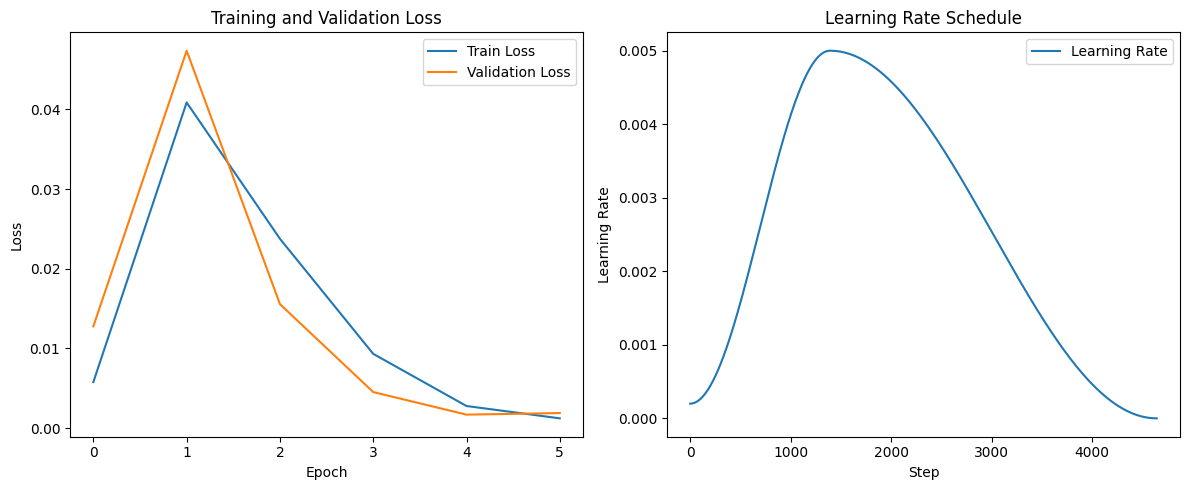

Epoch 1 completed
Average train loss: 0.001226423636855839
Average validation loss: 0.0014208421432014898
Epoch 2 completed
Average train loss: 0.000846330580586398
Average validation loss: 0.0008502559434849612
Epoch 3 completed
Average train loss: 0.0003316497084835895
Average validation loss: 0.0002120634968665208
Epoch 4 completed
Average train loss: 0.00021478877068310153
Average validation loss: 0.0004007687586731902
Epoch 5 completed
Average train loss: 0.0001553437057130992
Average validation loss: 0.00015239834123062073
Epoch 6 completed
Average train loss: 0.00011848221316151198
Average validation loss: 0.00011991190402975343
Epoch 7 completed
Average train loss: 6.50200765953659e-05
Average validation loss: 0.00012323681962219494
Epoch 8 completed
Average train loss: 4.189580957087153e-05
Average validation loss: 0.00012700729147534156
Epoch 9 completed
Average train loss: 2.7044648310198417e-05
Average validation loss: 9.474506388965222e-05
Epoch 10 completed
Average train 

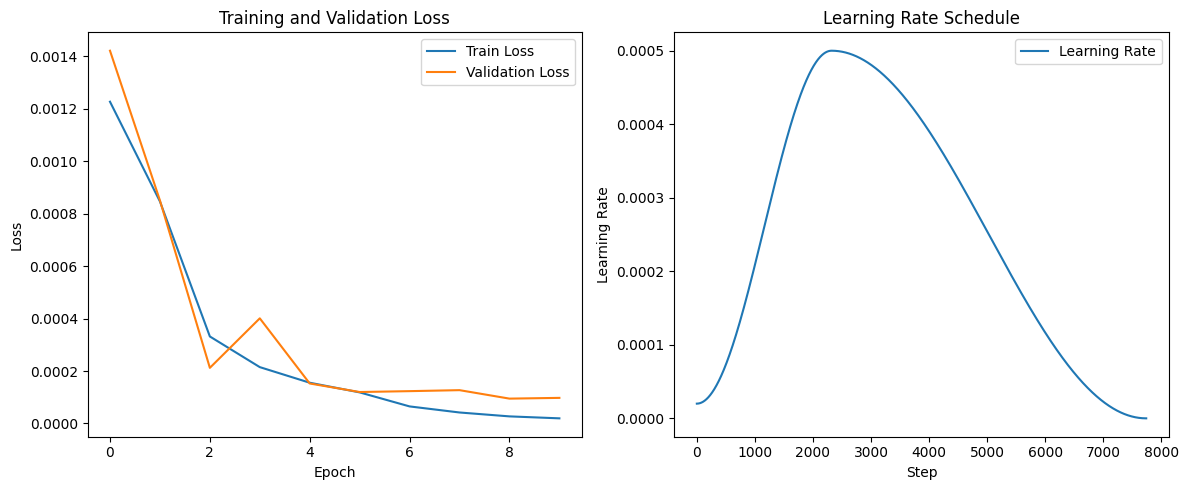

In [14]:
classifier_epochs = 6
full_epochs = 10
learning_rate = 0.0005
weight_decay = 0.01

# Define loss
criterion = nn.MSELoss()

# Load pre-trained model
model_effnetb0 = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1, in_chans=1)

# Reset the parameters of the classifier
model_effnetb0.classifier = nn.Linear(model_effnetb0.classifier.in_features, 1)

# Freeze all layers except the classifier
for param in model_effnetb0.parameters():
    param.requires_grad = False
for param in model_effnetb0.classifier.parameters():
    param.requires_grad = True
    
classifier_opt = optim.AdamW(model_effnetb0.classifier.parameters(), lr=learning_rate)

# Use DataParallel for multi-GPU training
if torch.cuda.device_count() > 1:
    model_effnetb0 = nn.DataParallel(model_effnetb0)

model_effnetb0.to(device)

train_and_validate(model_effnetb0, train_loader, validation_loader, criterion, classifier_opt, classifier_epochs, learning_rate*10)

# Unfreeze all layers
for param in model_effnetb0.parameters():
    param.requires_grad = True

full_opt = optim.AdamW(model_effnetb0.parameters(), lr=learning_rate/10, weight_decay=weight_decay)

train_and_validate(model_effnetb0, train_loader, validation_loader, criterion, full_opt, full_epochs, learning_rate)

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

Epoch 1 completed
Average train loss: 0.00504946692968207
Average validation loss: 0.007133704489158271
Epoch 2 completed
Average train loss: 0.020505269791096754
Average validation loss: 0.02296509461379365
Epoch 3 completed
Average train loss: 0.011329478015821608
Average validation loss: 0.011347797962738887
Epoch 4 completed
Average train loss: 0.005369573313658573
Average validation loss: 0.00263466205261035
Epoch 5 completed
Average train loss: 0.0014693040896744762
Average validation loss: 0.0010251327935532715
Epoch 6 completed
Average train loss: 0.000649864148795073
Average validation loss: 0.000918918921103652


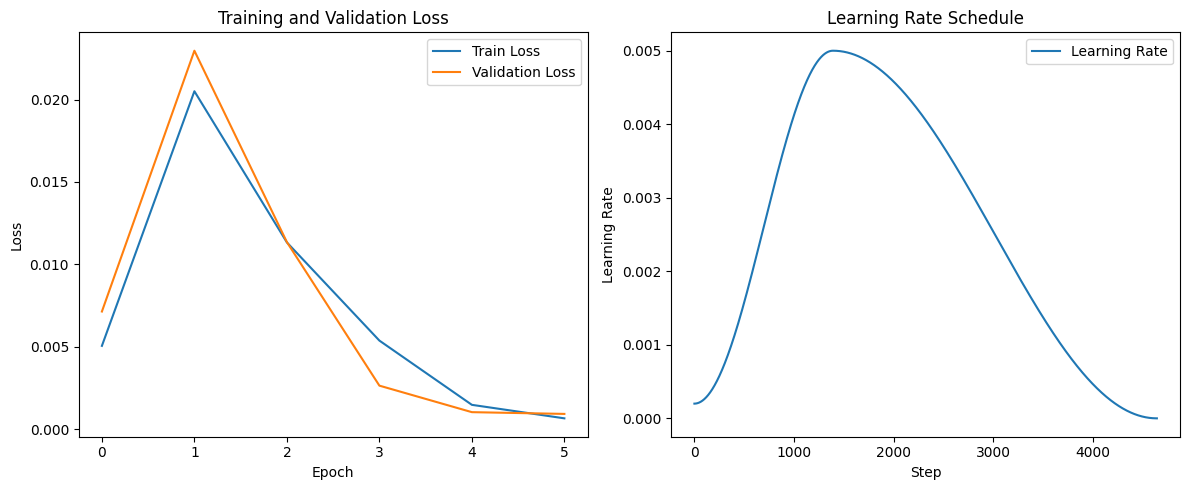

Epoch 1 completed
Average train loss: 0.0006243348592060988
Average validation loss: 0.0024160797712331834
Epoch 2 completed
Average train loss: 0.0006404046130686653
Average validation loss: 0.0014893846271565724
Epoch 3 completed
Average train loss: 0.00048804531456234513
Average validation loss: 0.00029204188611306323
Epoch 4 completed
Average train loss: 0.000261167002346856
Average validation loss: 0.00021266518985229546
Epoch 5 completed
Average train loss: 0.0002004607861251788
Average validation loss: 0.00024627626963161963
Epoch 6 completed
Average train loss: 0.00011738086456331282
Average validation loss: 0.00027160493166440193
Epoch 7 completed
Average train loss: 7.100467608263732e-05
Average validation loss: 0.00011957103727486116
Epoch 8 completed
Average train loss: 4.268728405120839e-05
Average validation loss: 0.00012987647415971688
Epoch 9 completed
Average train loss: 2.6561662497494444e-05
Average validation loss: 0.00011390714605927075
Epoch 10 completed
Average t

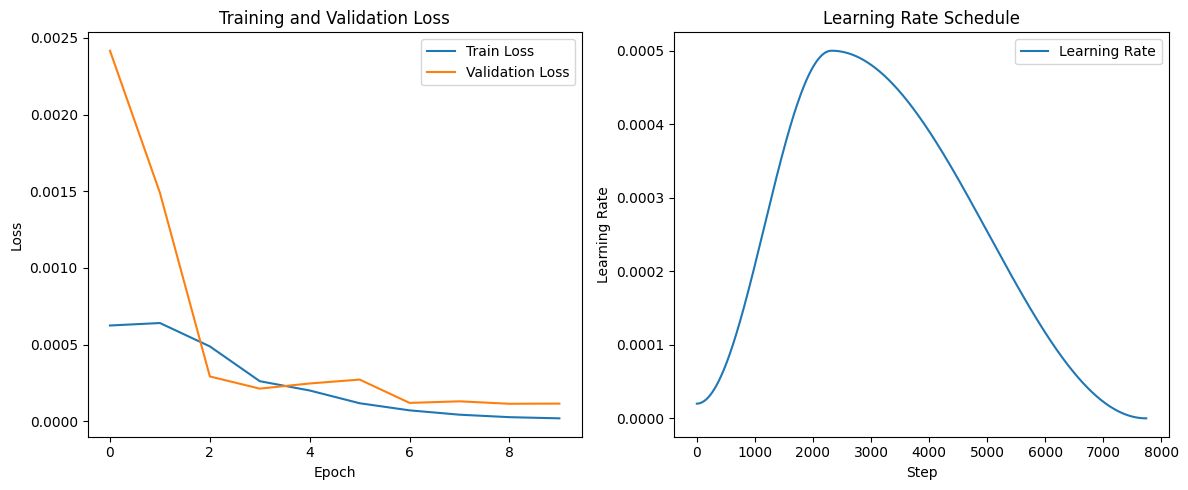

In [15]:
classifier_epochs = 6
full_epochs = 10
learning_rate = 0.0005
weight_decay = 0.01

# Define loss
criterion = nn.MSELoss()

# Load pre-trained model
model_mobnetv3 = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=1, in_chans=1)

# Modify the classifier to match your requirements
model_mobnetv3.classifier = nn.Linear(model_mobnetv3.classifier.in_features, 1)

# Freeze all layers except the classifier
for param in model_mobnetv3.parameters():
    param.requires_grad = False
for param in model_mobnetv3.classifier.parameters():
    param.requires_grad = True
    
classifier_opt = optim.AdamW(model_mobnetv3.classifier.parameters(), lr=learning_rate)

# Use DataParallel for multi-GPU training
if torch.cuda.device_count() > 1:
    model_mobnetv3 = nn.DataParallel(model_mobnetv3)

model_mobnetv3.to(device)

train_and_validate(model_mobnetv3, train_loader, validation_loader, criterion, classifier_opt, classifier_epochs, learning_rate*10)

# Unfreeze all layers
for param in model_mobnetv3.parameters():
    param.requires_grad = True

full_opt = optim.AdamW(model_mobnetv3.parameters(), lr=learning_rate/10, weight_decay=weight_decay)

train_and_validate(model_mobnetv3, train_loader, validation_loader, criterion, full_opt, full_epochs, learning_rate)

## Evaluation

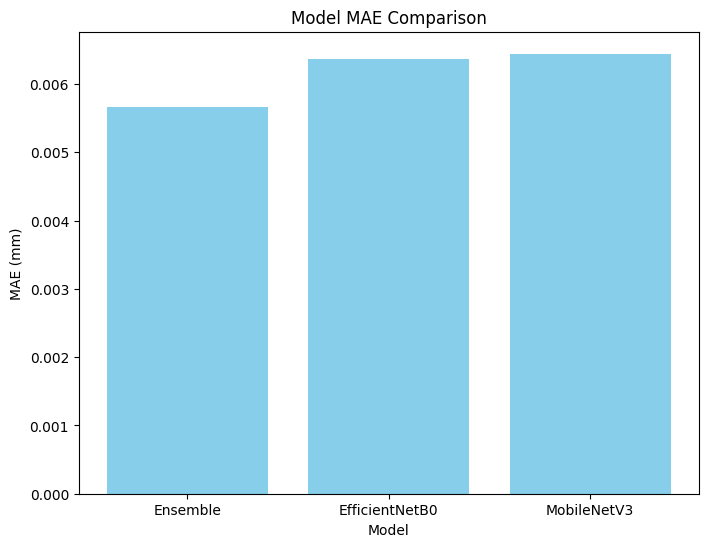

Ensemble MAE (mm): 0.0057
EfficientNetB0 MAE (mm): 0.0064
MobileNetV3 MAE (mm): 0.0064


In [16]:
from sklearn.metrics import mean_absolute_error

def evaluate_model_mae(models, dataloader):
    if not isinstance(models, list):
        models = [models]
    
    # Set all models to evaluation mode
    for model in models:
        model.eval()
    
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch[:2]
            inputs, targets = inputs.to(device), targets.to(device)

            if len(models) == 1:
                # Single model case
                outputs = models[0](inputs).cpu().numpy()
            else:
                # Ensemble case
                outputs = sum(model(inputs).cpu().numpy() for model in models) / len(models)
            
            all_preds.append(outputs)
            all_targets.append(targets.cpu().numpy())

    # Convert lists to arrays for metric calculations
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    mae = mean_absolute_error(all_targets, all_preds)
    
    return mae

# Models list
models = [model_effnetb0, model_mobnetv3]
model_names = ["EfficientNetB0", "MobileNetV3"]

# Evaluate MAE for each model individually
maes = []
for model in models:
    mae = evaluate_model_mae(model, validation_loader)
    maes.append(mae)

# Evaluate MAE for the ensemble of all models
ensemble_mae = evaluate_model_mae(models, validation_loader)
maes.append(ensemble_mae)

# Combine model names and MAEs into a list of tuples
model_mae_pairs = list(zip(model_names + ["Ensemble"], maes))

# Sort the models and MAEs in ascending order of MAE (lower is better)
model_mae_pairs.sort(key=lambda x: x[1])

# Unzip the sorted pairs back into two lists
sorted_model_names, sorted_maes = zip(*model_mae_pairs)

# Plotting the MAE results
plt.figure(figsize=(8, 6))
plt.bar(sorted_model_names, sorted_maes, color='skyblue')
plt.xlabel('Model')
plt.ylabel('MAE (mm)')
plt.title('Model MAE Comparison')
plt.show()

# Print the MAE results
for name, mae in model_mae_pairs:
    print(f'{name} MAE (mm): {mae:.4f}')

In [17]:
from collections import Counter

def classify_error_range(error, range_size=0.01):
    range_start = (error // range_size) * range_size
    range_end = range_start + range_size
    return f"{range_start:.2f}-{range_end:.2f}"

def calculate_model_accuracy(models, validation_loader, threshold=0.01):
    total_samples = 0
    correct_predictions = 0
    saved_values = []
    error_ranges = []

    single_batch_validation_loader = DataLoader(validation_loader.dataset, batch_size=1, shuffle=False)

    for i, (X_val, y_val, circumference, _) in enumerate(single_batch_validation_loader):
        X_val = X_val.to(device)

        with torch.no_grad():
            for model in models:
                model.eval()
                
            # Forward pass and average predictions across models
            y_pred = sum(model(X_val).item() for model in models) / len(models)

            # Convert predictions and actual values to numpy array
            y_val_np = y_val.item()

            # Calculate accuracy based on the condition
            error = abs(y_pred - y_val_np)
            if error <= threshold:
                correct_predictions += 1
            else:
                saved_values.append(int(circumference / 10))
                error_range = classify_error_range(error)
                error_ranges.append(error_range)

            total_samples += 1
    
    # Calculate average accuracy
    average_accuracy = correct_predictions / total_samples

    return average_accuracy, saved_values, error_ranges

def plot_value_counts(saved_values):
    counts = Counter(saved_values)
    values = list(counts.keys())
    occurrences = list(counts.values())

    plt.bar(values, occurrences)
    plt.xlabel('Circumference')
    plt.ylabel('Occurrences')
    plt.title('Count of Circumference Ranges')
    plt.show()

def plot_error_counts(error_ranges):
    counts = Counter(error_ranges)
    ranges = list(counts.keys())
    occurrences = list(counts.values())

    # Convert range strings to tuples of floats for sorting
    parsed_ranges = [(float(r.split('-')[0]), float(r.split('-')[1])) for r in ranges]
    sorted_indices = sorted(range(len(parsed_ranges)), key=lambda i: parsed_ranges[i])

    # Sort ranges and occurrences based on the sorted indices
    sorted_ranges = [ranges[i] for i in sorted_indices]
    sorted_occurrences = [occurrences[i] for i in sorted_indices]

    plt.bar(sorted_ranges, sorted_occurrences)
    plt.xlabel('Error Range (mm)')
    plt.ylabel('Occurrences')
    plt.title('Count of Errors by Range')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### The variable `saved_values` contains the number of incorrect predictions (beyond the threshold) in each 10 mm range of circumference (similar to the class distribution at the beginning). To see the number of incorrect prediction for each 0.01 distance range from the actual answer you can use `error_ranges`.

In [18]:
# Calculate accuracies and save values
models = [model_effnetb0, model_mobnetv3]
en_average_accuracy, en_saved_values, en_error_ranges = calculate_model_accuracy(models, validation_loader)
eff_average_accuracy, eff_saved_values, eff_error_ranges = calculate_model_accuracy([model_effnetb0], validation_loader)
mob_average_accuracy, mob_saved_values, mob_error_ranges = calculate_model_accuracy([model_mobnetv3], validation_loader)

print(f'Ensemble accuracy: {en_average_accuracy:.4f}')
print(f'Effnetb0 accuracy: {eff_average_accuracy:.4f}')
print(f'Mobnetv3 accuracy: {mob_average_accuracy:.4f}')

Ensemble accuracy: 0.8770
Effnetb0 accuracy: 0.8289
Mobnetv3 accuracy: 0.8556


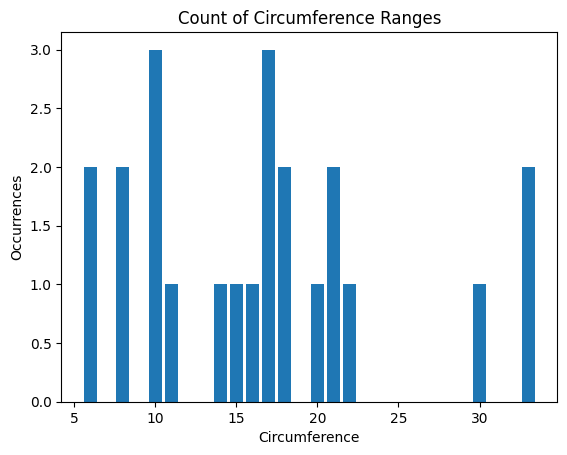

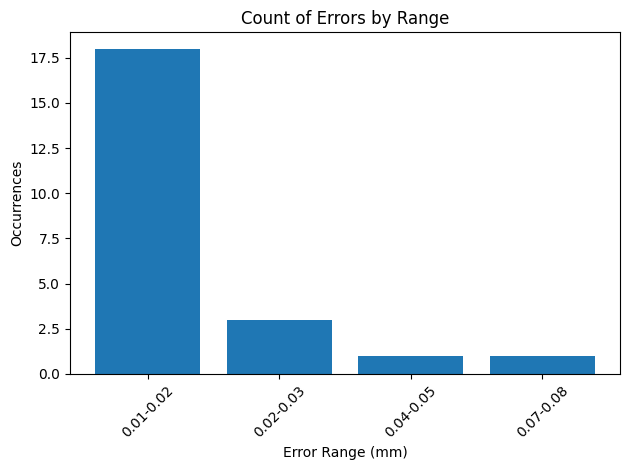

In [19]:
plot_value_counts(en_saved_values)
plot_error_counts(en_error_ranges)

## Download models

In [21]:
model_path_1 = "model_effnetb0.pth"
torch.save(model_effnetb0.state_dict(), model_path_1)

model_path_2 = "model_mobnetv3.pth"
torch.save(model_mobnetv3.state_dict(), model_path_2)